# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import dataframe_image as dfi
import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### COVID-19 Cases

In [3]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")

radar_covid_countries = {"Spain"}
# radar_covid_regions = { ... }

confirmed_df = confirmed_df[confirmed_df["Country_EN"].isin(radar_covid_countries)]
# confirmed_df = confirmed_df[confirmed_df["Region"].isin(radar_covid_regions)]
# set(confirmed_df.Region.tolist()) == radar_covid_regions

In [4]:
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df = confirmed_df.sum().to_frame()
confirmed_df.tail()

,0
2020-09-12,1132652.0
2020-09-13,1132652.0
2020-09-14,1187460.0
2020-09-15,1206334.0
2020-09-16,1228720.0


In [5]:
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
233,2020-09-12,1132652.0,0.0,19239.142857
234,2020-09-13,1132652.0,0.0,19239.142857
235,2020-09-14,1187460.0,54808.0,19480.285714
236,2020-09-15,1206334.0,18874.0,19615.428571
237,2020-09-16,1228720.0,22386.0,20280.285714


In [6]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.rolling_mean_new_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)
        
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
234,2020-09-13,1.132652e+06,0.000000,19239.142857
235,2020-09-14,1.187460e+06,54808.000000,19480.285714
236,2020-09-15,1.206334e+06,18874.000000,19615.428571
237,2020-09-16,1.228720e+06,22386.000000,20280.285714
237,2020-09-17,1.249000e+06,20280.285714,20280.285714


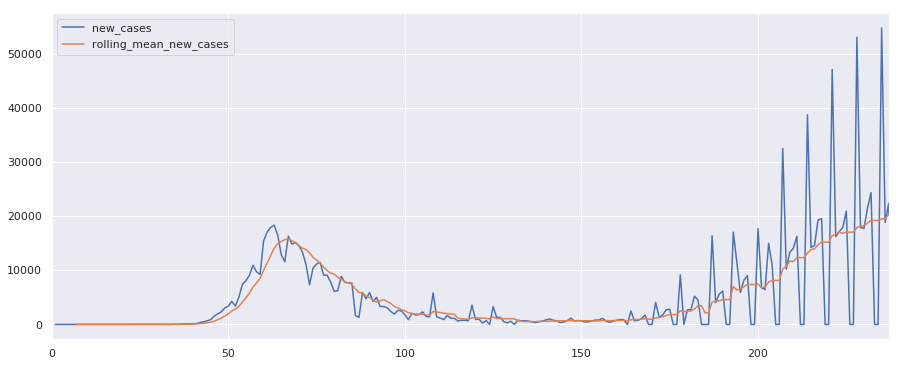

In [7]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

### Extract API TEKs

In [8]:
from Modules.RadarCOVID import radar_covid

exposure_keys_df = radar_covid.download_last_radar_covid_exposure_keys(days=14)
exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]].head()

Traceback (most recent call last):
  File "/home/runner/work/RadarCOVID-Report/RadarCOVID-Report/Modules/RadarCOVID/radar_covid.py", line 125, in download_last_radar_covid_exposure_keys
    date_exposure_keys_df = download_radar_covid_exposure_keys(date=sample_datetime)
  File "/home/runner/work/RadarCOVID-Report/RadarCOVID-Report/Modules/RadarCOVID/radar_covid.py", line 85, in download_radar_covid_exposure_keys
    raise Exception(
Exception: Invalid key 'key_rolling_period': 48600s (expected: 86400s)


,sample_date_string,source_url,region,key_data
0,2020-09-15,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,f6f1a72b-e029-5cc3-06ca-7817dc59b26e
1,2020-09-15,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,422efa32-d305-8dd2-0951-e80622129c3b
2,2020-09-15,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,0a89a931-ac24-f72b-dddd-b7146c054a5b
3,2020-09-15,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,97b58fe2-6123-0bf5-68a7-a56ae18860b6
4,2020-09-15,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,a3183441-2760-18bc-c713-6240585aadd8


In [9]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
exposure_keys_summary_df.head()

,tek_count
sample_date_string,
2020-09-15,23
2020-09-14,34
2020-09-13,48
2020-09-12,59
2020-09-11,75


### Dump API TEKs

In [10]:
tek_list_df = exposure_keys_df[["sample_date_string", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    "sample_date").tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour
tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    "Data/TEKs/Current/RadarCOVID-TEKs.json",
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,2020-09-04,"[98aa2cae-2aa8-2211-af28-d71ebe061675, a2a0a01...",2020-09-17,2020-09-17@07
1,2020-09-05,"[2630f115-d3d6-6d09-c4c3-761802f15ab9, 6634443...",2020-09-17,2020-09-17@07
2,2020-09-06,"[385e7ed2-4285-fcfd-18e4-3197e44fc261, d484384...",2020-09-17,2020-09-17@07
3,2020-09-07,"[4f22f269-acd0-9cbd-5082-87826578c387, 402a892...",2020-09-17,2020-09-17@07
4,2020-09-08,"[64d2f594-3e1e-250e-b2e2-103c46f3a4a9, b8121a9...",2020-09-17,2020-09-17@07


### Load TEK Dumps

In [11]:
import glob

def load_extracted_teks(mode, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame()
    paths = list(reversed(sorted(glob.glob(f"Data/TEKs/{mode}/RadarCOVID-TEKs-*.json"))))
    if limit:
        paths = paths[:limit]
    for path in paths:
        logging.info(f"Loading TEKs from '{path}'...")
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    return extracted_teks_df

### Daily New TEKs

In [12]:
daily_extracted_teks_df = load_extracted_teks(mode="Daily", limit=14)
daily_extracted_teks_df.head()

,sample_date,tek_list,extraction_date
0,2020-09-04,"[98aa2cae-2aa8-2211-af28-d71ebe061675, a2a0a01...",2020-09-17
1,2020-09-05,"[2630f115-d3d6-6d09-c4c3-761802f15ab9, 6634443...",2020-09-17
2,2020-09-06,"[385e7ed2-4285-fcfd-18e4-3197e44fc261, d484384...",2020-09-17
3,2020-09-07,"[4f22f269-acd0-9cbd-5082-87826578c387, 402a892...",2020-09-17
4,2020-09-08,"[64d2f594-3e1e-250e-b2e2-103c46f3a4a9, b8121a9...",2020-09-17


In [13]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-09-04,"{ac9affc2-6e1c-0d50-14ac-5bc60966abae, d7334bc..."
2020-09-05,"{d7334bc7-fa30-4df9-5c18-6ede83cf848d, 4148f5b..."
2020-09-06,"{d7334bc7-fa30-4df9-5c18-6ede83cf848d, 4148f5b..."
2020-09-07,"{4148f5b7-c2c9-224f-6f4b-ea054a366e73, b14b234..."
2020-09-08,"{4148f5b7-c2c9-224f-6f4b-ea054a366e73, b14b234..."


In [14]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "new_tek_count",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.head()

,sample_date_string,new_tek_count
0,2020-09-04,NaN
1,2020-09-05,40.0
2,2020-09-06,60.0
3,2020-09-07,52.0
4,2020-09-08,44.0


In [15]:
new_tek_devices_df = daily_extracted_teks_df.copy()
new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(new_tek_devices_df.sample_date) + datetime.timedelta(1)
new_tek_devices_df["extraction_date"] = pd.to_datetime(new_tek_devices_df.extraction_date)

new_tek_devices_df = new_tek_devices_df[
    new_tek_devices_df.new_sample_extraction_date == new_tek_devices_df.extraction_date]
new_tek_devices_df.head()

,sample_date,tek_list,extraction_date,new_sample_extraction_date
12,2020-09-15,"[f6f1a72b-e029-5cc3-06ca-7817dc59b26e, 422efa3...",2020-09-16,2020-09-16
12,2020-09-14,"[d4bfbea7-3eaf-535f-3faa-aaedf929f579, ae4ae0c...",2020-09-15,2020-09-15
12,2020-09-13,"[505d0ee6-f270-c93c-754d-1b8a5d8a4a27, 7a3b8a8...",2020-09-14,2020-09-14
12,2020-09-12,"[b6e3bd50-c556-ff3b-56af-0fe6d728dc4b, 213621e...",2020-09-13,2020-09-13
12,2020-09-11,"[37f3f2da-307f-8df3-01ba-e05b5aee182e, 6d3415f...",2020-09-12,2020-09-12


In [16]:
new_tek_devices_df.set_index("extraction_date", inplace=True)
new_tek_devices_df = new_tek_devices_df.tek_list.apply(lambda x: len(set(x))).to_frame()
new_tek_devices_df.reset_index(inplace=True)
new_tek_devices_df.rename(columns={
    "extraction_date": "sample_date_string",
    "tek_list": "new_tek_devices"}, inplace=True)
new_tek_devices_df["sample_date_string"] = new_tek_devices_df.sample_date_string.dt.strftime("%Y-%m-%d")
new_tek_devices_df.head()

,sample_date_string,new_tek_devices
0,2020-09-16,23
1,2020-09-15,23
2,2020-09-14,28
3,2020-09-13,32
4,2020-09-12,33


### Hourly New TEKs

In [17]:
hourly_extracted_teks_df = load_extracted_teks(mode="Hourly", limit=24)
hourly_extracted_teks_df.head()

hourly_tek_list_df = hourly_extracted_teks_df.groupby("extraction_date_with_hour").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
hourly_tek_list_df = hourly_tek_list_df.set_index("extraction_date_with_hour").sort_index(ascending=True)

hourly_new_tek_df = hourly_tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
hourly_new_tek_df.rename(columns={
    "tek_list": "new_tek_count"}, inplace=True)
hourly_new_tek_df.tail()

,extraction_date_with_hour,new_tek_count
19,2020-09-17@03,0.0
20,2020-09-17@04,0.0
21,2020-09-17@05,0.0
22,2020-09-17@06,0.0
23,2020-09-17@07,0.0


In [18]:
hourly_new_tek_devices_df = hourly_extracted_teks_df.copy()
hourly_new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_new_tek_devices_df.sample_date) + datetime.timedelta(1)
hourly_new_tek_devices_df["extraction_date"] = pd.to_datetime(hourly_new_tek_devices_df.extraction_date)

hourly_new_tek_devices_df = hourly_new_tek_devices_df[
    hourly_new_tek_devices_df.new_sample_extraction_date == hourly_new_tek_devices_df.extraction_date]

hourly_new_tek_devices_df.set_index("extraction_date_with_hour", inplace=True)
hourly_new_tek_devices_df_ = pd.DataFrame()

for i, chunk_df in hourly_new_tek_devices_df.groupby("extraction_date"):
    chunk_df = chunk_df.copy()
    chunk_df.sort_index(inplace=True)
    chunk_tek_count_df = chunk_df.tek_list.apply(lambda x: len(set(x)))
    chunk_df = chunk_tek_count_df.diff().fillna(chunk_tek_count_df).to_frame()
    hourly_new_tek_devices_df_ = hourly_new_tek_devices_df_.append(chunk_df)
    
hourly_new_tek_devices_df = hourly_new_tek_devices_df_
hourly_new_tek_devices_df.reset_index(inplace=True)
hourly_new_tek_devices_df.rename(columns={
    "tek_list": "new_tek_devices"}, inplace=True)
hourly_new_tek_devices_df.tail()

,extraction_date_with_hour,new_tek_devices
11,2020-09-16@19,0.0
12,2020-09-16@20,0.0
13,2020-09-16@21,0.0
14,2020-09-16@22,0.0
15,2020-09-16@23,0.0


In [19]:
hourly_summary_df = hourly_new_tek_df.merge(
    hourly_new_tek_devices_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df.tail()

,extraction_date_with_hour,new_tek_count,new_tek_devices
datetime_utc,,,
2020-09-17 03:00:00,2020-09-17@03,0.0,NaN
2020-09-17 04:00:00,2020-09-17@04,0.0,NaN
2020-09-17 05:00:00,2020-09-17@05,0.0,NaN
2020-09-17 06:00:00,2020-09-17@06,0.0,NaN
2020-09-17 07:00:00,2020-09-17@07,0.0,NaN


### Data Merge

In [20]:
result_summary_df = exposure_keys_summary_df.merge(new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count
0,2020-09-15,23.0,58.0
1,2020-09-14,34.0,61.0
2,2020-09-13,48.0,92.0
3,2020-09-12,59.0,92.0
4,2020-09-11,75.0,46.0


In [21]:
result_summary_df = result_summary_df.merge(new_tek_devices_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices
0,2020-09-15,23.0,58.0,23.0
1,2020-09-14,34.0,61.0,28.0
2,2020-09-13,48.0,92.0,32.0
3,2020-09-12,59.0,92.0,33.0
4,2020-09-11,75.0,46.0,19.0


In [22]:
result_summary_df = result_summary_df.merge(confirmed_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-09-15,23.0,58.0,23.0,1206334.0,18874.0,19615.428571
1,2020-09-14,34.0,61.0,28.0,1187460.0,54808.0,19480.285714
2,2020-09-13,48.0,92.0,32.0,1132652.0,0.0,19239.142857
3,2020-09-12,59.0,92.0,33.0,1132652.0,0.0,19239.142857
4,2020-09-11,75.0,46.0,19.0,1132652.0,24366.0,19239.142857


In [23]:
result_summary_df["tek_count_per_new_case"] = \
    result_summary_df.tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_case"] = \
    result_summary_df.new_tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_devices_per_new_case"] = \
    result_summary_df.new_tek_devices / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_tek_device"] = \
    result_summary_df.new_tek_count / result_summary_df.new_tek_devices
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
0,2020-09-15,23.0,58.0,23.0,1206334.0,18874.0,19615.428571,0.001173,0.002957,0.001173,2.521739
1,2020-09-14,34.0,61.0,28.0,1187460.0,54808.0,19480.285714,0.001745,0.003131,0.001437,2.178571
2,2020-09-13,48.0,92.0,32.0,1132652.0,0.0,19239.142857,0.002495,0.004782,0.001663,2.875000
3,2020-09-12,59.0,92.0,33.0,1132652.0,0.0,19239.142857,0.003067,0.004782,0.001715,2.787879
4,2020-09-11,75.0,46.0,19.0,1132652.0,24366.0,19239.142857,0.003898,0.002391,0.000988,2.421053


In [24]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df = result_summary_df.sort_index(ascending=False)

## Report Results


### Summary Table

In [25]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[[
    "tek_count",
    "new_tek_count",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_new_case",
    "new_tek_count_per_new_case",
    "new_tek_devices",
    "new_tek_devices_per_new_case",
    "new_tek_count_per_new_tek_device"]]
result_summary_df

,tek_count,new_tek_count,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
sample_date,,,,,,,,,
2020-09-17,NaN,0.0,20280.285714,20280.285714,NaN,0.000000,NaN,NaN,NaN
2020-09-16,NaN,62.0,22386.000000,20280.285714,NaN,0.003057,23.0,0.001134,2.695652
2020-09-15,23.0,58.0,18874.000000,19615.428571,0.001173,0.002957,23.0,0.001173,2.521739
2020-09-14,34.0,61.0,54808.000000,19480.285714,0.001745,0.003131,28.0,0.001437,2.178571
2020-09-13,48.0,92.0,0.000000,19239.142857,0.002495,0.004782,32.0,0.001663,2.875000
2020-09-12,59.0,92.0,0.000000,19239.142857,0.003067,0.004782,33.0,0.001715,2.787879
2020-09-11,75.0,46.0,24366.000000,19239.142857,0.003898,0.002391,19.0,0.000988,2.421053
2020-09-10,68.0,45.0,21528.000000,18751.428571,0.003626,0.002400,15.0,0.000800,3.000000
2020-09-09,60.0,67.0,17732.000000,18235.714286,0.003290,0.003674,21.0,0.001152,3.190476


### Summary Plots

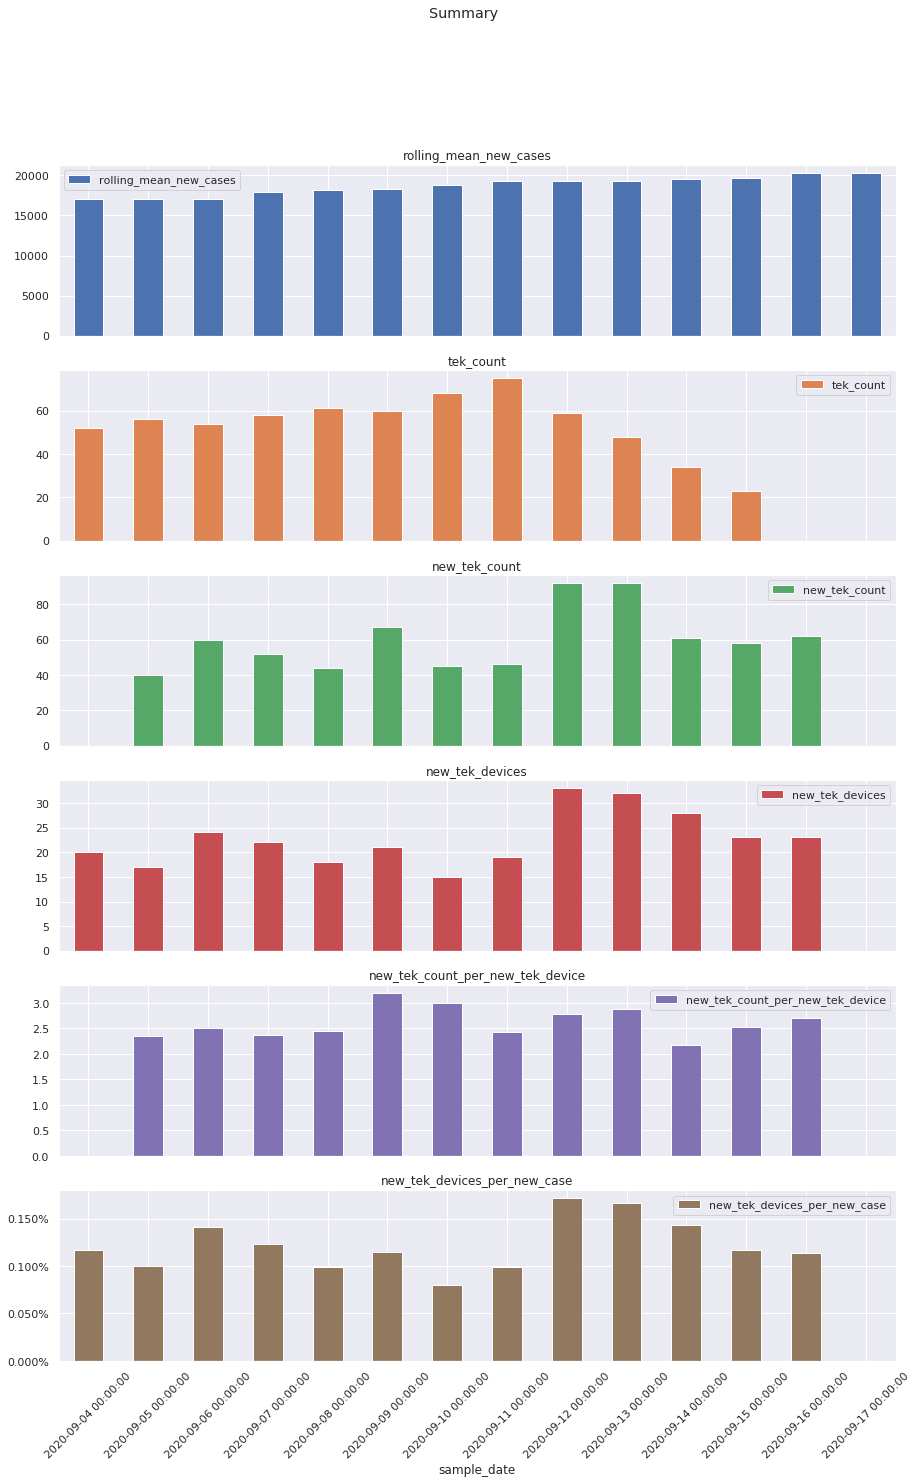

In [26]:
summary_ax_list = result_summary_df[[
    "rolling_mean_new_cases",
    "tek_count",
    "new_tek_count",
    "new_tek_devices",
    "new_tek_count_per_new_tek_device",
    "new_tek_devices_per_new_case"
]].sort_index(ascending=True).plot.bar(
    title="Summary", rot=45, subplots=True, figsize=(15, 22))
summary_ax_list[-1].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

### Hourly Summary Plots 

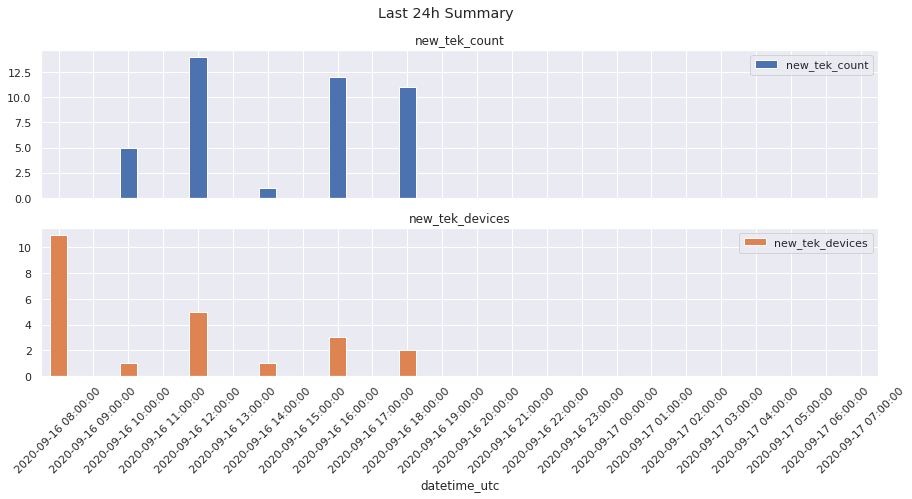

In [27]:
hourly_summary_ax_list = hourly_summary_df.plot.bar(
    title="Last 24h Summary", rot=45, subplots=True)

### Publish Results

In [28]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

summary_plots_image_path = save_temporary_plot_image(ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(df=result_summary_df)
hourly_summary_plots_image_path = save_temporary_plot_image(ax=hourly_summary_ax_list)

### Save Results

In [29]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(report_resources_path_prefix + "Summary-Table.html")
_ = shutil.copyfile(summary_plots_image_path, report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(summary_table_image_path, report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(hourly_summary_plots_image_path, report_resources_path_prefix + "Hourly-Summary-Plots.png")

report_daily_url_pattern = \
    "https://github.com/pvieito/RadarCOVID-Report/blob/master/Notebooks/" \
    "RadarCOVID-Report/{report_type}/RadarCOVID-Report-{report_date}.ipynb"
report_daily_url = report_daily_url_pattern.format(
    report_type="Daily", report_date=extraction_date)
report_hourly_url = report_daily_url_pattern.format(
    report_type="Hourly", report_date=extraction_date_with_hour)

### Publish on README

In [30]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

summary_table_html = result_summary_df.to_html()
readme_contents = readme_contents.format(
    summary_table_html=summary_table_html,
    report_url_with_hour=report_hourly_url,
    extraction_date_with_hour=extraction_date_with_hour)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [31]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    hourly_summary_plots_media = api.media_upload(hourly_summary_plots_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        hourly_summary_plots_media.media_id,
    ]

    extraction_date_result_summary_df = \
        result_summary_df[result_summary_df.index == extraction_date]
    extraction_date_result_hourly_summary_df = \
        hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

    new_teks = extraction_date_result_summary_df.new_tek_count.sum().astype(int)
    new_teks_last_hour = extraction_date_result_hourly_summary_df.new_tek_count.sum().astype(int)
    new_devices = extraction_date_result_summary_df.new_tek_devices.sum().astype(int)
    new_devices_last_hour = extraction_date_result_hourly_summary_df.new_tek_devices.sum().astype(int)
    new_tek_count_per_new_tek_device = \
        extraction_date_result_summary_df.new_tek_count_per_new_tek_device.sum()
    new_tek_devices_per_new_case = \
        extraction_date_result_summary_df.new_tek_devices_per_new_case.sum()

    status = textwrap.dedent(f"""
        Report Update – {extraction_date_with_hour}
        #ExposureNotification #RadarCOVID

        Shared Diagnoses Day Summary:
        - New TEKs: {new_teks} ({new_teks_last_hour:+d} last hour)
        - New Devices: {new_devices} ({new_devices_last_hour:+d} last hour, {new_tek_count_per_new_tek_device:.2} TEKs/device)
        - Usage Ratio: {new_tek_devices_per_new_case:.2%} devices/case

        Report Link: {report_hourly_url}
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)